In [1]:
import unicodedata
import pandas as pd
import numpy as np
import string
import sys
import re
import sklearn
import nltk

from nltk import FreqDist
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import  SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, plot_roc_curve, roc_curve, auc, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2

import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

np.set_printoptions(linewidth=100)
%autosave 120

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/yamasjose/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/yamasjose/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/yamasjose/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Autosaving every 120 seconds


###  Importing Data

In [2]:
# # Importing the Data on Google Colab
# from google.colab import files

# uploaded = files.upload()

# twitter = pd.read_csv('gender-classifier-DFE-791531.csv', encoding='latin-1' )

In [3]:
twitter = pd.read_csv('data/gender-classifier-DFE-791531.csv', encoding='latin-1' )

The dataset contains the following fields:

**unit_id:** a unique id for user

**golden:** whether the user was included in the gold standard for the model; TRUE or FALSE

**unit_state:** state of the observation; one of finalized (for contributor-judged) or golden (for gold standard observations)

**trusted_judgments:** number of trusted judgments (int); always 3 for non-golden, and what may be a unique id for gold standard observations

**last_judgment_at:** date and time of last contributor judgment; blank for gold standard observations

**gender:** one of male, female, or brand (for non-human profiles)

**gender:confidence:** a float representing confidence in the provided gender

**profile_yn:** "no" here seems to mean that the profile was meant to be part of the dataset but was not available when contributors went to judge it

**profile_yn:confidence:** confidence in the existence/non-existence of the profile

**created:** date and time when the profile was created

**description:** the user's profile description

**fav_number:** number of tweets the user has favorited

**gender_gold:** if the profile is golden, what is the gender?

**link_color:** the link color on the profile, as a hex value

**name:** the user's name

**profile_yn_gold:** whether the profile y/n value is golden

**profileimage:** a link to the profile image

**retweet_count:** number of times the user has retweeted (or possibly, been retweeted)

**sidebar_color:** color of the profile sidebar, as a hex value

**text:** text of a random one of the user's tweets

**tweet_coord:** if the user has location turned on, the coordinates as a string with the format "[latitude, longitude]"

**tweet_count:** number of tweets that the user has posted

**tweet_created:** when the random tweet (in the text column) was created

**tweet_id:** the tweet id of the random tweet

**tweet_location:** location of the tweet; seems to not be particularly normalized

**user_timezone:** the timezone of the user

In [4]:
pd.set_option('display.max_columns', None)

twitter.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,description,fav_number,gender_gold,link_color,name,profile_yn_gold,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,i sing my own rhythm.,0,NaN,08C2C2,sheezy0,NaN,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,I'm the author of novels filled with family dr...,68,NaN,0084B4,DavdBurnett,NaN,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,louis whining and squealing and all,7696,NaN,ABB8C2,lwtprettylaugh,NaN,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202,NaN,0084B4,douggarland,NaN,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,37318,NaN,3B94D9,WilfordGemma,NaN,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN


In [5]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               20050 non-null  int64  
 1   _golden                20050 non-null  bool   
 2   _unit_state            20050 non-null  object 
 3   _trusted_judgments     20050 non-null  int64  
 4   _last_judgment_at      20000 non-null  object 
 5   gender                 19953 non-null  object 
 6   gender:confidence      20024 non-null  float64
 7   profile_yn             20050 non-null  object 
 8   profile_yn:confidence  20050 non-null  float64
 9   created                20050 non-null  object 
 10  description            16306 non-null  object 
 11  fav_number             20050 non-null  int64  
 12  gender_gold            50 non-null     object 
 13  link_color             20050 non-null  object 
 14  name                   20050 non-null  object 
 15  pr

## Data Analysis


In [6]:
twitter = twitter.drop(['_golden', '_unit_state', '_trusted_judgments', 'profile_yn', 'gender_gold', 'profile_yn_gold', 'tweet_coord', 'tweet_location', 'user_timezone'], axis = 1) 
# clean_df

In [7]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               20050 non-null  int64  
 1   _last_judgment_at      20000 non-null  object 
 2   gender                 19953 non-null  object 
 3   gender:confidence      20024 non-null  float64
 4   profile_yn:confidence  20050 non-null  float64
 5   created                20050 non-null  object 
 6   description            16306 non-null  object 
 7   fav_number             20050 non-null  int64  
 8   link_color             20050 non-null  object 
 9   name                   20050 non-null  object 
 10  profileimage           20050 non-null  object 
 11  retweet_count          20050 non-null  int64  
 12  sidebar_color          20050 non-null  object 
 13  text                   20050 non-null  object 
 14  tweet_count            20050 non-null  int64  
 15  tw

In [8]:
# fill in missing data
twitter.fillna(value = 'unknown',  
          inplace = True) 

In [9]:
# twitter.info()

In [10]:
twitter.gender.value_counts()

female     6700
male       6194
brand      5942
unknown    1214
Name: gender, dtype: int64

## NLP Pipeline 

Below is a to do list when converting text into vector form: 

**Clean text and Create a Bag of Words (BoW)**
>1. Lowercase the text
2. Tokenize 
3. Strip out punctuation or undesirable text
4. Remove Stopwords 
5. Stemming or Lemmatizing
6. Compute N-Grams
7. Use this to create BoW

**Vectorize BoW**
>8. Term Frequencies
9. Document Frequencies
10. TF-IDF
11. Normalize vectors



In [11]:
classes = twitter['gender']
print(classes.value_counts())

female     6700
male       6194
brand      5942
unknown    1214
Name: gender, dtype: int64


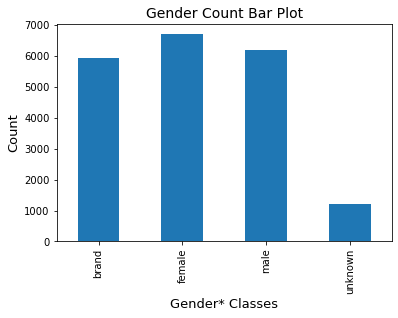

In [12]:
# tweets per gender per data
twitter.groupby('gender').text.count().plot.bar(ylim=0)
plt.xlabel('Gender* Classes', size=13)
plt.ylabel('Count', size=13)
plt.title("Gender Count Bar Plot", size=14)
plt.show()

In [13]:
encoder = LabelEncoder()
Y = encoder.fit_transform(classes)

# print(classes[:15])
print(Y[:15])

[2 2 2 2 1 1 0 2 1 1 0 0 1 0 1]


In [14]:
twitter.text[:15]

0     Robbie E Responds To Critics After Win Against...
1     ÛÏIt felt like they were my friends and I was...
2     i absolutely adore when louis starts the songs...
3     Hi @JordanSpieth - Looking at the url - do you...
4     Watching Neighbours on Sky+ catching up with t...
5     Ive seen people on the train with lamps, chair...
6     @BpackEngineer Thank you for your patience whi...
7     Gala Bingo clubs bought for å£241m: The UK's l...
8     @_Aphmau_ the pic defines all mcd fangirls/fan...
9     @Evielady just how lovely is the tree this yea...
10    how are you taking care of yourself? https://t...
11    MTG Deals 1x Rank-Up-Magic - The Seventh One -...
12    Just put my ass on the line for you and this i...
13    https://t.co/z4sbWUugd8 What the Nation Will B...
14    will i even need sound effects for the diviner...
Name: text, dtype: object

In [15]:
tweets = twitter.text
tweets

0        Robbie E Responds To Critics After Win Against...
1        ÛÏIt felt like they were my friends and I was...
2        i absolutely adore when louis starts the songs...
3        Hi @JordanSpieth - Looking at the url - do you...
4        Watching Neighbours on Sky+ catching up with t...
                               ...                        
20045    @lookupondeath ...Fine, and I'll drink tea too...
20046    Greg Hardy you a good player and all but don't...
20047    You can miss people and still never want to se...
20048    @bitemyapp i had noticed your tendency to pee ...
20049    I think for my APUSH creative project I'm goin...
Name: text, Length: 20050, dtype: object

###   Text Processing

In [16]:
pt = string.punctuation
pt

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [17]:
# # removing @s and links
# for i,doc in enumerate(tweets):
#     tweets[i] = re.sub(r"(?:\@|https?\://)\S+", "", doc)
#     tweets[i] = " ".join(tweets[i].split())
# # tweets[:15]

# # We will analyze not using emojis and re iterate through the same data with emojis

# # let's start by removing emojis and other special characters
# for i,doc in enumerate(tweets):
#     tweets[i] = unicodedata.normalize('NFKD', doc).encode('ASCII', 'ignore').decode('utf8')

# # tweets, len(tweets)

# # clean punctuation
# tweets = tweets.str.replace(r'[^\w\d\s]', ' ')
# # clean_tweets[:20]

# clean numbers
# tweets = tweets.str.replace(r'\d+(\.\d+)?', ' ')
# tweets[:20]

# clean whitespaces
# tweets = tweets.str.replace(r'\s+', ' ')
# tweets[:20]

# clean extra whitespaces
# tweets = tweets.str.replace(r'^\s+|\s+?$', '')
# tweets[:20]

# lower
# tweets = tweets.str.lower()
# tweets[:20]

In [18]:
def clean_data(tweets):

#     # removing @s and links
#     for i,doc in enumerate(tweets):
#         tweets[i] = re.sub(r"(?:\@|https?\://)\S+", "", doc)
#         tweets[i] = " ".join(tweets[i].split())

#     ### We will analyze not using emojis and re iterate through the same data with emojis

#     # let's start by removing emojis and other special characters
#     for i,doc in enumerate(tweets):
#         tweets[i] = unicodedata.normalize('NFKD', doc).encode('ASCII', 'ignore').decode('utf8')

    # removing @s and links
    tweets = tweets.str.replace(r"(?:\@|https?\://)\S+", '')
    
    ## let's start by removing emojis and other special characters
    #tweets = unicodedata.normalize('NFKD', tweets).encode('ASCII', 'ignore').decode('utf8')
        
    # clean punctuation
    tweets = tweets.str.replace(r'[^\w\d\s]', ' ')

    # clean numbers
    tweets = tweets.str.replace(r'\d+(\.\d+)?', ' ')
    
    # remove underscores 
    #tweets1 = tweets1.str.replace(r'[^_',  '')
    tweets = tweets.str.replace(r"(\.\d+)_\d+", ' ')
    
    # clean whitespaces
    tweets = tweets.str.replace(r'\s+', ' ')

    # clean extra whitespaces
    tweets = tweets.str.replace(r'^\s+|\s+?$', '')
    
    # lowercase text
    tweets = tweets.str.lower()
    
    # remove stop words
    stop_words = set(stopwords.words('english'))
    tweets = tweets.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
    
    
    return tweets

In [19]:
df = twitter[twitter['gender'] != 'unknown']
# df.info()

df = df.reset_index()
# df.info()

In [20]:
# Applying text processing
# tweets = tweets.apply(clean_data)
tweets_df = clean_data(df.text)

In [21]:
# remove stop words
extras = ['a', 'e', 'i', 'o', 'u', 'https']
stop_words = set(stopwords.words('english'))
stop_words.update(extras)

# Applying the removal of stop words
tweets_df = tweets_df.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
tweets_df[:15]

0     robbie responds critics win eddie edwards worl...
1     ûïit felt like friends living story û retired ian
2     absolutely adore louis starts songs hits hard ...
3        hi looking url use typically see advanced user
4     watching neighbours sky catching neighbs xxx _...
5            ive seen people train lamps chairs tvs etc
6                        thank patience take care issue
7     gala bingo clubs bought å uk largest high stre...
8      pic defines mcd fangirls fanboys mcd shippers xd
9     lovely tree year never seen gorgeous autumn co...
10                             taking care fitfluential
11    mtg deals x rank magic seventh one prio en sec...
12                                   put ass line repay
13        nation talking wednesday gop debates business
14             even need sound effects diviners tonight
Name: text, dtype: object

### Stemming and/ or Lemmatizing

In [22]:
# SnowballStemmer
def stem(text):
  stemmer = SnowballStemmer('english')
  return ''.join([stemmer.stem(word) for word in text])

# Lemmatizing
def lem(text):
  lemmatizer = WordNetLemmatizer()
  return ''.join([lemmatizer.lemmatize(word) for word in text])

In [23]:
text_stem = tweets_df.apply(stem)

In [24]:
text_lem = tweets_df.apply(lem)

### Creating a Bag of Words (BoW)

In [25]:
class0_df = twitter[twitter.gender != 'male'].reset_index()
class1_df = twitter[twitter.gender != 'female'].reset_index()
class2_df = twitter[twitter.gender != 'brand'].reset_index()
class3_df = twitter[twitter.gender != 'unknown'].reset_index()

In [26]:
class0_df.transcript_lem = class0_df.text.apply(lem)
class1_df.transcript_lem = class1_df.text.apply(lem)
class2_df.transcript_lem = class2_df.text.apply(lem)
class3_df.transcript_lem = class3_df.text.apply(lem)

/home/yamasjose/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.
/home/yamasjose/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/home/yamasjose/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until
/home/yamasjose/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via 

In [27]:
# # Creating a Bag of Words

bow_df, class0_bow, class1_bow, class2_bow, class3_bow = [], [], [], [], []

for trans in text_stem:
    words = word_tokenize(trans)
    for w in words:
        bow_df.append(w)
bow_df = nltk.FreqDist(bow_df)

for trans0 in class0_df.transcript_lem:
    words0 = word_tokenize(trans0)
    for w0 in words0:
        class0_bow.append(w0)
class0_bow = nltk.FreqDist(class0_bow)

for trans1 in class1_df.transcript_lem:
    words1 = word_tokenize(trans1)
    for w1 in words1:
        class1_bow.append(w1)
class1_bow = nltk.FreqDist(class1_bow)

for trans2 in class2_df.transcript_lem:
    words2 = word_tokenize(trans2)
    for w2 in words2:
        class2_bow.append(w2)
class2_bow = nltk.FreqDist(class2_bow)

for trans3 in class3_df.transcript_lem:
    words3 = word_tokenize(trans3)
    for w3 in words3:
        class3_bow.append(w3)
class3_bow = nltk.FreqDist(class3_bow)


In [28]:
# B.O.W - For all Corpus
print('Bag of Words Count for all: {}'.format(len(bow_df)))
print('Most Frequent Words for all: {}'.format((bow_df.most_common(10))))
print('\n')
# B.O.W - Class 0
print('Bag of Words Count for Class 0: {}'.format(len(class0_bow)))
print('Most Frequent Words for Class 0: {}'.format((class0_bow.most_common(10))))
print('\n')
# B.O.W - Class 1
print('Bag of Words Count for Class 1: {}'.format(len(class1_bow)))
print('Most Frequent Words for Class 1: {}'.format((class1_bow.most_common(10))))
print('\n')
# B.O.W - Class 2
print('Bag of Words Count for Class 2: {}'.format(len(class2_bow)))
print('Most Frequent Words for Class 2: {}'.format((class2_bow.most_common(10))))
print('\n')
# B.O.W - Class 3
print('Bag of Words Count for Class 3: {}'.format(len(class3_bow)))
print('Most Frequent Words for Class 3: {}'.format((class3_bow.most_common(10))))

Bag of Words Count for all: 25245
Most Frequent Words for all: [('weather', 2307), ('get', 2027), ('_ù', 1440), ('channel', 1183), ('updates', 1155), ('like', 957), ('one', 753), ('û_', 716), ('love', 680), ('new', 673)]


Bag of Words Count for Class 0: 40200
Most Frequent Words for Class 0: [(':', 8607), ('and', 7758), ('the', 7524), ('https', 6457), ('.', 6101), ('#', 5625), ('@', 5346), ('I', 4099), (',', 3947), ('to', 3887)]


Bag of Words Count for Class 1: 40869
Most Frequent Words for Class 1: [(':', 8534), ('the', 7736), ('and', 7093), ('.', 6656), ('https', 6371), ('@', 6226), ('#', 5293), (',', 4342), ('to', 3613), ('I', 3062)]


Bag of Words Count for Class 2: 39555
Most Frequent Words for Class 2: [('the', 8988), ('and', 8743), ('@', 7244), ('.', 6471), (':', 5975), ('I', 5550), ('https', 4449), ('to', 4415), (',', 4275), ('#', 4077)]


Bag of Words Count for Class 3: 51319
Most Frequent Words for Class 3: [('the', 11158), (':', 10877), ('and', 10867), ('.', 8627), ('@', 8

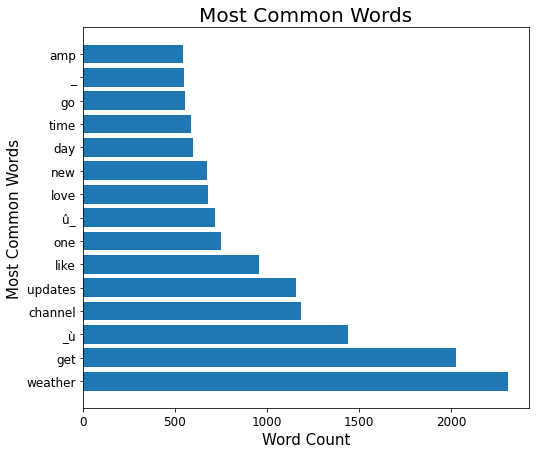

In [29]:
# Getting Most Common Words n - Histogram
n = 15
most_bow = list(zip(*bow_df.most_common(n)))

fig, ax = plt.subplots(figsize=(8,7))
plt.barh(most_bow[0], most_bow[1])
plt.title('Most Common Words', size=20)
plt.xlabel('Word Count', size=15)
plt.ylabel('Most Common Words', size=15)
plt.xticks(size=12, rotation=0)
plt.yticks(size=12, rotation=0)
plt.show()

## Machine Learning Pipeline using Random Forest Classifier
* Removing Unknown Gender Class from dataframe

In [30]:
new_df = twitter[twitter['gender'] != 'unknown']
new_df = new_df.reset_index()
# new_df1.info()

In [31]:
# Text Processing without unknown class 
tweets_df = clean_data(new_df.text)
text_stem = tweets_df.apply(stem)

In [32]:
len(new_df.gender), len(text_stem)

(18836, 18836)

In [33]:
X = text_lem
y = new_df.gender
# X, y

In [34]:
encoder = LabelEncoder()
Y = encoder.fit_transform(y)

# Y = Y.astype('int')
# print(Y[:30])

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
# X_train, X_test, y_train, y_test

In [36]:
## ## Pipeline Build - tfdifvectorizer use
pipe = Pipeline([ ('vect', CountVectorizer()),
                  ('tfidf', TfidfTransformer()),
                  ('clf', RandomForestClassifier())])

pipe.fit(X_train, y_train)


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier())])

In [37]:
tf_vec = TfidfVectorizer()
tf_vec_ft = tf_vec.fit_transform(X_train)
tf_vec_ft.shape

(15068, 22243)

In [38]:
tf_vec.vocabulary_

{'ever': 6610,
 'go': 8107,
 'youtube': 21865,
 'watch': 21102,
 'music': 12845,
 'video': 20793,
 'hours': 9259,
 'later': 10942,
 'find': 7151,
 'watching': 21106,
 'tutorial': 20148,
 'talk': 19071,
 'giraffes': 8024,
 'going': 8134,
 'need': 13063,
 'young': 21854,
 'priest': 15096,
 'old': 13674,
 'winchesters': 21413,
 'reasons': 15803,
 'possesedbaby': 14878,
 'orphan': 13876,
 'drug': 5904,
 'interpretive': 9936,
 'rule': 16616,
 'struck': 18648,
 'district': 5583,
 'court': 4463,
 'hhs': 8958,
 'hrsa': 9299,
 'lose': 11498,
 'overwrought': 13990,
 'media': 12147,
 'scare': 16891,
 'campaigns': 3042,
 'internet': 9928,
 'really': 15789,
 'enjoyed': 6411,
 'redoaks': 15885,
 'took': 19771,
 'back': 1555,
 'awesome': 1506,
 'decade': 5020,
 'big': 2087,
 'hair': 8567,
 'short': 17443,
 'shorts': 17450,
 'least': 11054,
 'fave': 6950,
 'self': 17118,
 'titled': 19672,
 'easy': 6066,
 'idk': 9486,
 'fearless': 6983,
 'speak': 18133,
 'red': 15867,
 'got': 8207,
 'car': 3123,
 'smel

In [39]:
tf_vec_ft.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [40]:
rf = RandomForestClassifier()

rf.fit(tf_vec_ft, y_train)

RandomForestClassifier()

In [41]:
tf_vec_ft_test = tf_vec.transform(X_test)
tf_vec_ft_test.shape

(3768, 22243)

In [42]:
rf_pred = rf.predict(tf_vec_ft_test)

In [43]:
rf.score(tf_vec_ft_test, y_test)

0.5352972399150743

In [44]:
tf_feat_names = tf_vec.get_feature_names() 
tf_feat_names = np.array(tf_feat_names)

# len(tf_feat_names), type(tf_feat_names)

In [45]:
feat_imp = rf.feature_importances_
feat_imp

array([5.77071784e-05, 5.14250500e-07, 2.13376416e-06, ..., 5.71874455e-06, 9.57748873e-06,
       4.63346754e-06])

In [46]:
feat_imp_10 = np.argsort(feat_imp)[-10:]

In [47]:
sorted_imp = np.argsort(feat_imp)[-10:]
sorted_imp

array([ 8107, 11537, 13718, 22131, 11258, 20526,    58,  3426,  7952, 21155])

In [48]:
feat_imp_words = tf_feat_names[np.argsort(feat_imp)][-10:]
feat_imp_words

array(['go', 'love', 'one', 'û_', 'like', 'updates', '_ù', 'channel', 'get', 'weather'],
      dtype='<U89')

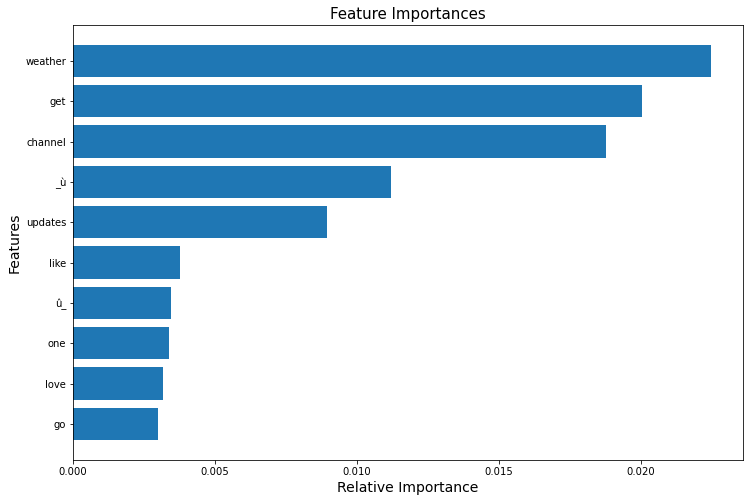

In [49]:
# Plot the feature importances of the forest
fig, ax = plt.subplots(figsize=(12, 8))

plt.title('Feature Importances', size=15)
plt.barh(range(len(sorted_imp)), feat_imp[sorted_imp], align='center')
plt.yticks(range(len(sorted_imp)),feat_imp_words )
plt.xlabel('Relative Importance', size=14)
plt.ylabel('Features', size=14)
plt.savefig('images/feature_imp.png')
plt.show()

In [50]:
ytest = np.array(y_test)
ytest

array([1, 0, 2, ..., 1, 0, 2])

In [51]:
y_pred = pipe.predict(X_test)

# y_pred = y_pred.astype('int')
# y_pred[:75]

In [52]:
# len(ytest), len(y_pred), type(ytest), type(y_pred)
# pipel4.get_params().keys()

In [53]:
print('Accuracy = ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy =  0.5342356687898089
              precision    recall  f1-score   support

           0       0.66      0.54      0.59      1203
           1       0.54      0.62      0.58      1397
           2       0.42      0.43      0.43      1168

    accuracy                           0.53      3768
   macro avg       0.54      0.53      0.53      3768
weighted avg       0.54      0.53      0.54      3768



In [54]:
# print(confusion_matrix(y_test, y_pred))

In [55]:
print(confusion_matrix(y_test, y_pred))
conf_matrx = confusion_matrix(y_test, y_pred)

# sn.heatmap(conf_matrx)

[[650 263 290]
 [141 862 394]
 [195 472 501]]


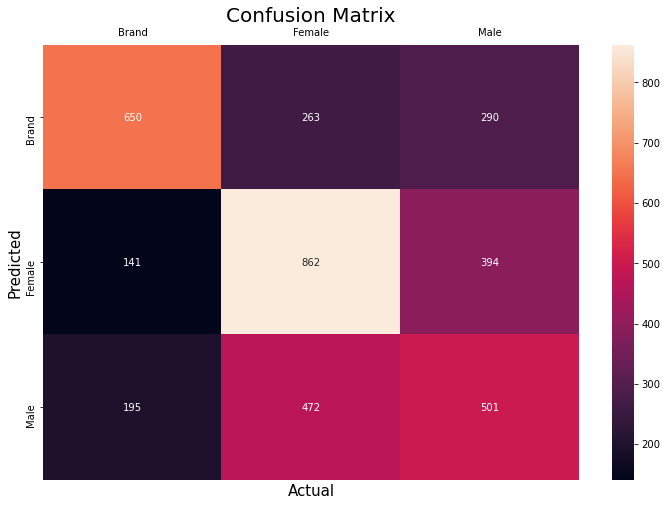

In [56]:
categories=['Brand','Female','Male']
fig, ax = plt.subplots(figsize=(12,8))
sn.heatmap(confusion_matrix(ytest, pipe.predict(X_test)), annot=True, fmt='g', xticklabels=categories, yticklabels=categories, ax=ax)
ax.set_title('Confusion Matrix', fontsize=20)
ax.set_xlabel('Actual',fontsize=15)
ax.set_ylabel('Predicted',fontsize=15)
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)
plt.savefig('images/base_heatmap.png')

## Machine Learning Pipeline using Random Forest Classifier
* Removing Unknown and Brand Gender Class from dataframe

In [57]:
# Remove Unknown Class - Gender
new_df2 = twitter[twitter['gender'] != 'unknown']
new_df2 = new_df2.reset_index()
# new_df2.info()

In [58]:
# Remove Brand Class - Gender
new_df2 = new_df2[new_df2['gender'] != 'brand']
new_df2 = new_df2.reset_index()

# df_b_uk.info()

In [59]:
# Text Processing without unknown class 
tweets_df2 = clean_data(new_df2.text)
text_stem2 = tweets_df2.apply(stem)


In [60]:
len(new_df2.gender), len(text_stem2)

(12894, 12894)

In [61]:
X = text_stem2
Y = new_df2.gender

In [62]:
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
# # Y = Y.astype('int')
# print(classes[:15])
print(Y[:25])

[1 1 1 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0]


In [63]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
# X_train, X_test, y_train, y_test

In [64]:
## Pipeline Build 
pipeline_bi = Pipeline([('vect', CountVectorizer()), 
                  ('tfidf', TfidfTransformer()),
                  ('clf', RandomForestClassifier())])

pipeline_bi.fit(X_train, Y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier())])

In [65]:
Ytest = np.array(Y_test)
Ytest

array([0, 1, 0, ..., 1, 1, 0])

In [66]:
Y_pred = pipeline_bi.predict(X_test)

Y_pred = Y_pred.astype('int')
# Y_pred[:75]

In [67]:
print('Accuracy = ', accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Accuracy =  0.5773555641721597
              precision    recall  f1-score   support

           0       0.59      0.66      0.62      1358
           1       0.56      0.49      0.52      1221

    accuracy                           0.58      2579
   macro avg       0.58      0.57      0.57      2579
weighted avg       0.58      0.58      0.57      2579



In [68]:
print(confusion_matrix(Y_test, Y_pred))
conf_matrx = confusion_matrix(Y_test, Y_pred)

# sn.heatmap(conf_matrx)

[[894 464]
 [626 595]]


In [69]:
conf_matrx = confusion_matrix(Ytest, Y_pred)

# sn.heatmap(conf_matrx)

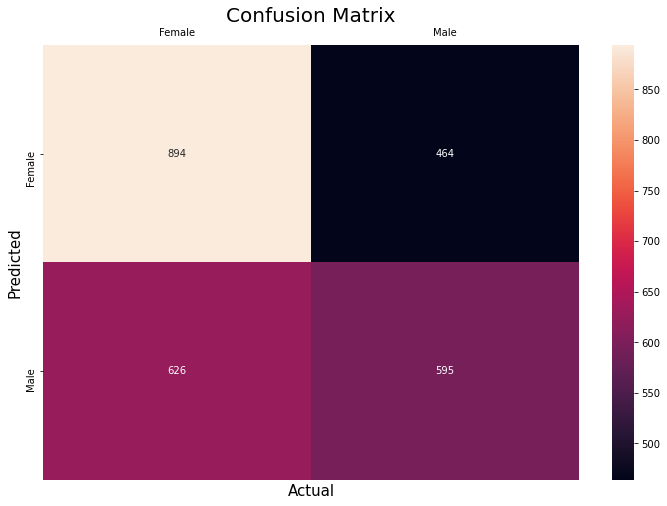

In [70]:
categories=['Female','Male']
fig, ax = plt.subplots(figsize=(12,8))
sn.heatmap(confusion_matrix(Ytest, pipeline_bi.predict(X_test)), annot=True, fmt='g', xticklabels=categories, yticklabels=categories, ax=ax)
ax.set_title('Confusion Matrix', fontsize=20)
ax.set_xlabel('Actual',fontsize=15)
ax.set_ylabel('Predicted',fontsize=15)
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)
plt.savefig('images/base_heatmap2.png')

In [71]:
tf_vec = TfidfVectorizer()

tf_vec_ft = tf_vec.fit_transform(X_train)
tf_vec_ft.shape

(10315, 17247)

In [72]:
# tf_vec.vocabulary_

In [73]:
tf_vec_ft.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [74]:
rf = RandomForestClassifier()

rf.fit(tf_vec_ft, Y_train)

RandomForestClassifier()

In [75]:
tf_vec_ft_test = tf_vec.transform(X_test)
tf_vec_ft_test.shape

(2579, 17247)

In [76]:
# tf_vec_ft_test

In [77]:
rf_pred = rf.predict(tf_vec_ft_test)

In [78]:
rf.score(tf_vec_ft_test, Y_test)

0.5874369910818147

In [79]:
tf_feat_names = tf_vec.get_feature_names() 
tf_feat_names = np.array(tf_feat_names)

len(tf_feat_names), type(tf_feat_names)

(17247, numpy.ndarray)

In [80]:
feat_imp = rf.feature_importances_
feat_imp

array([7.90221410e-05, 7.97925281e-07, 1.05557645e-06, ..., 3.94405787e-05, 2.88236916e-05,
       8.44151235e-06])

In [81]:
feat_imp_10 = np.argsort(feat_imp)[-15:]

In [82]:
sorted_imp = np.argsort(feat_imp)[-15:]
sorted_imp

array([10182,  1587, 16342,  3876,  6358, 15204,  6082,  8322, 10609,  6317, 11102,  8959,  8725,
        6202,    46])

In [83]:
feat_imp_words = tf_feat_names[np.argsort(feat_imp)][-15:]
feat_imp_words

array(['new', 'best', 'want', 'day', 'good', 'time', 'game', 'know', 'one', 'go', 'people', 'love',
       'like', 'get', '_ù'], dtype='<U89')

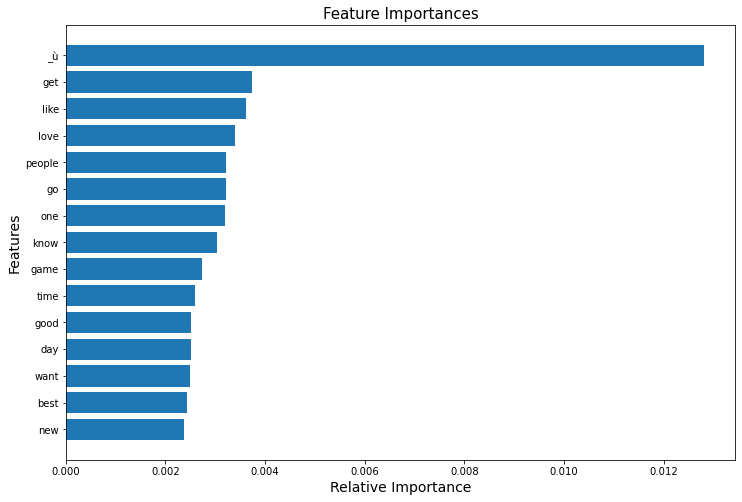

In [84]:
# Plot the feature importances of the forest
fig, ax = plt.subplots(figsize=(12, 8))

plt.title('Feature Importances', size=15)
plt.barh(range(len(sorted_imp)), feat_imp[sorted_imp], align='center')
plt.yticks(range(len(sorted_imp)),feat_imp_words )
plt.xlabel('Relative Importance', size=14)
plt.ylabel('Features', size=14)
plt.savefig('images/feature_imp3.png')
plt.show()

## Data Analysis Using other M.L Models
* Binary Classification for 'Male' and 'Female' Only

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB,MultinomialNB, GaussianNB
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier

In [86]:
x = text_stem2
Y = new_df2.gender

tfidf = TfidfVectorizer()
x = tfidf.fit_transform(x)

x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size = 0.2)

In [87]:
## List of ML Algorithms/ Model Classifiers
models = [LogisticRegression(),
          RandomForestClassifier(),
          GradientBoostingClassifier(),
          BernoulliNB() ]

In [88]:
for model in models:
    model.fit(x_train,Y_train)
    Y_pred = model.predict(x_test)
    proba = model.predict_proba(x_test)
    score = accuracy_score(Y_test,Y_pred)
    bin_clf_rep = classification_report(Y_test,Y_pred, zero_division=1)
    name = str(model)
    print(name[0:name.find("(")])
    print("Accuracy :", score)
    print(bin_clf_rep)
    print(confusion_matrix(Y_test,Y_pred))
    print("------------------------------------------------------------")

LogisticRegression
Accuracy : 0.5893757270259791
              precision    recall  f1-score   support

      female       0.62      0.61      0.62      1393
        male       0.55      0.57      0.56      1186

    accuracy                           0.59      2579
   macro avg       0.59      0.59      0.59      2579
weighted avg       0.59      0.59      0.59      2579

[[847 546]
 [513 673]]
------------------------------------------------------------
RandomForestClassifier
Accuracy : 0.5955796820473052
              precision    recall  f1-score   support

      female       0.63      0.62      0.62      1393
        male       0.56      0.57      0.57      1186

    accuracy                           0.60      2579
   macro avg       0.59      0.59      0.59      2579
weighted avg       0.60      0.60      0.60      2579

[[857 536]
 [507 679]]
------------------------------------------------------------
GradientBoostingClassifier
Accuracy : 0.550601008142691
              precis

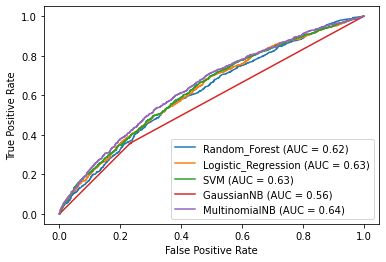

In [89]:
fig, ax = plt.subplots()

model_rf = RandomForestClassifier().fit(x_train, Y_train)
model_lr = LogisticRegression().fit(x_train, Y_train)
model_svm = SVC().fit(x_train, Y_train)
model_gnb = GaussianNB().fit(x_train.todense(), Y_train)
model_mnb = MultinomialNB().fit(x_train.todense(), Y_train)

plot_roc_curve(model_rf, x_test, Y_test, ax=ax, name='Random_Forest')
plot_roc_curve(model_lr, x_test, Y_test, ax=ax, name='Logistic_Regression')
plot_roc_curve(model_svm, x_test, Y_test, ax=ax, name='SVM')
plot_roc_curve(model_gnb, x_test.todense(), Y_test, ax=ax, name='GaussianNB')
plot_roc_curve(model_mnb, x_test.todense(), Y_test, ax=ax, name='MultinomialNB')
plt.show()